Starting 'cosine_restarts' on CPU
Starting 'const_1e-4' on CPU
Starting 'exp_decay' on CPUStarting 'cosine_decay' on CPU

Starting 'poly_decay' on CPU
Starting 'reduce_plateau' on CPU
Starting 'const_1e-2' on CPU
Starting 'piecewise' on CPU
Starting 'inv_time_decay' on CPU
Starting 'const_1e-3' on CPU


2025-06-17 00:25:32.980213: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-06-17 00:25:32.980252: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:167] env: CUDA_VISIBLE_DEVICES=""
2025-06-17 00:25:32.980261: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] CUDA_VISIBLE_DEVICES is set to an empty string - this hides all GPUs from CUDA
2025-06-17 00:25:32.980272: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-06-17 00:25:32.980276: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: kdplab01
2025-06-17 00:25:32.980279: I external/local_xla/xla/stream_executo

Completed 'cosine_restarts'
Completed 'const_1e-2'
Completed 'piecewise'
Completed 'exp_decay'
Completed 'poly_decay'
Completed 'reduce_plateau'
Completed 'const_1e-4'
Completed 'const_1e-3'
Completed 'cosine_decay'
Completed 'inv_time_decay'


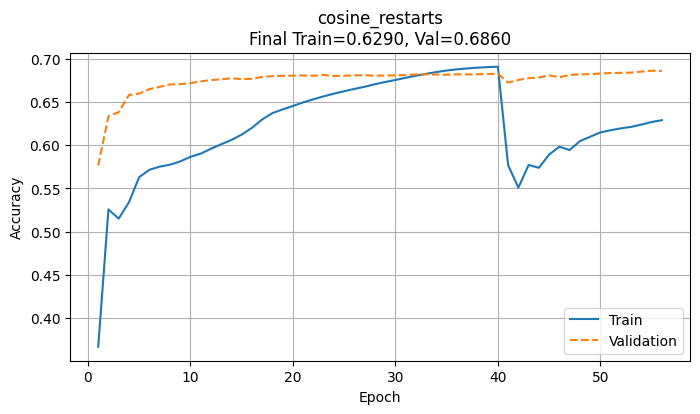

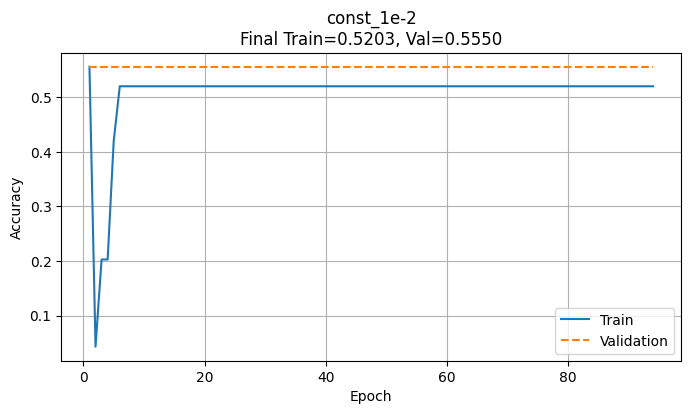

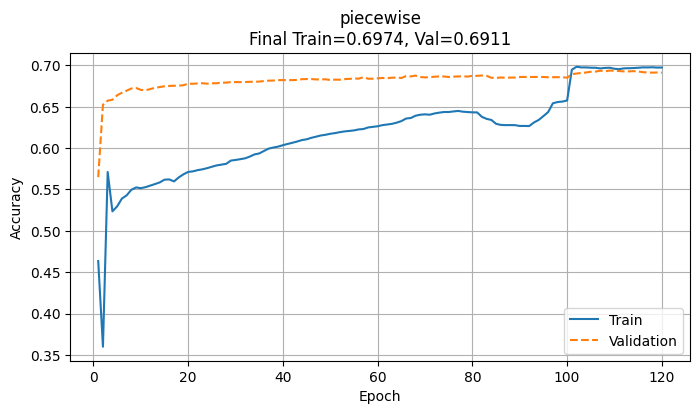

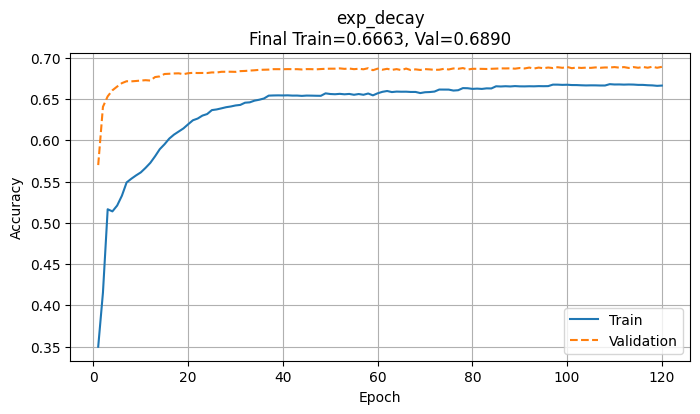

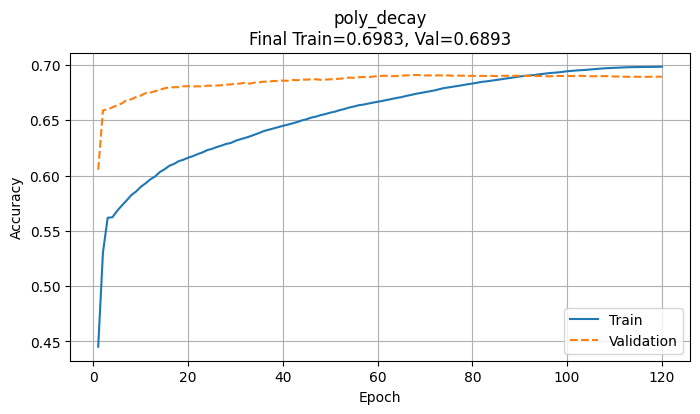

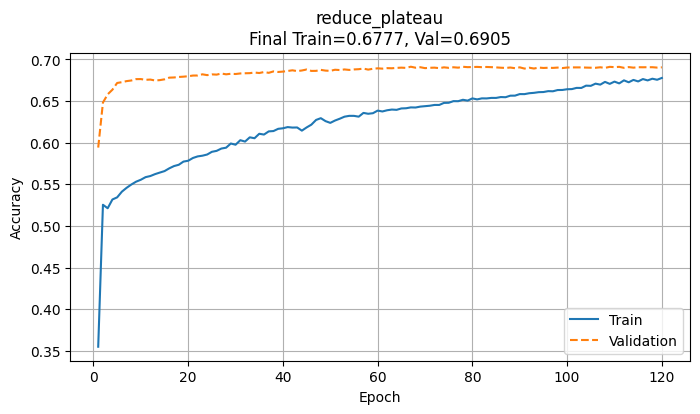

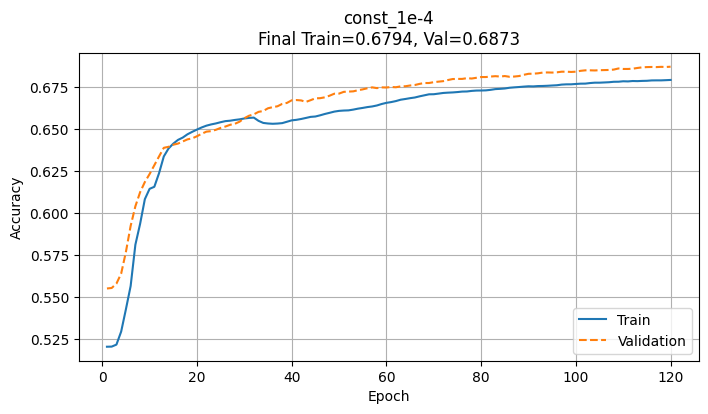

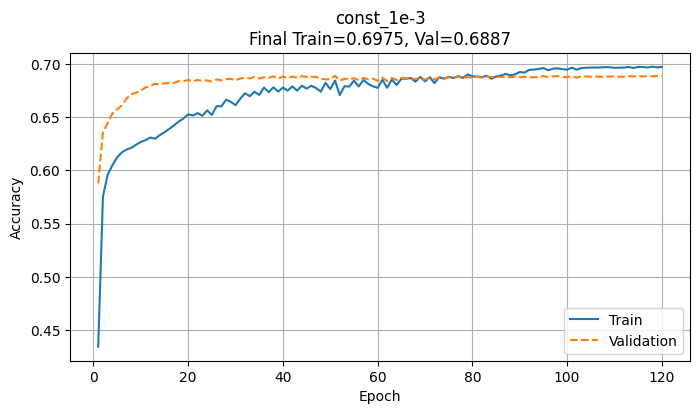

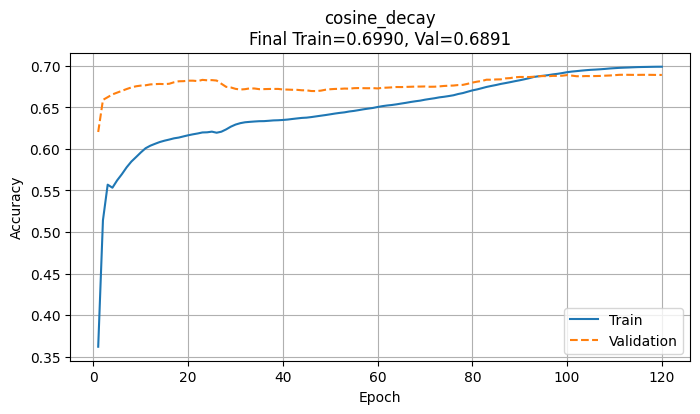

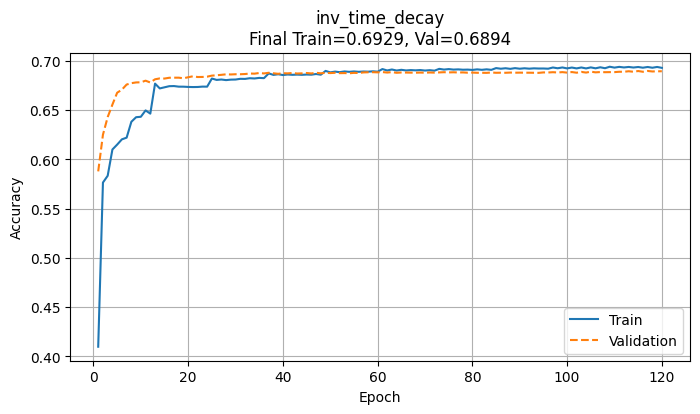

In [3]:
import sys
import os
from concurrent.futures import ProcessPoolExecutor, as_completed
from pathlib import Path
import matplotlib.pyplot as plt

# 1) Update this path to where OptimizedDataGenerator4.py resides
sys.path.append('.')  
os.environ['CUDA_VISIBLE_DEVICES'] = ''  # Force CPU-only

import OptimizedDataGenerator4 as ODG
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ─── Model definition ─────────────────────────────────────────────────────────
def CreateXYProfileModel():
    x = tf.keras.Input((21,1), name="x_profile")
    y = tf.keras.Input((13,1), name="y_profile")
    xf = tf.keras.layers.Flatten()(x)
    yf = tf.keras.layers.Flatten()(y)
    c  = tf.keras.layers.Concatenate()([xf, yf])
    h1 = tf.keras.layers.Dense(64, activation="relu")(c)
    h2 = tf.keras.layers.Dense(16, activation="relu")(h1)
    out= tf.keras.layers.Dense(1, activation="sigmoid")(h2)
    return tf.keras.Model([x, y], out)

# ─── Data generators factory ───────────────────────────────────────────────────
BASE_DIR       = Path("./filtering_records2000")
TRAIN_DIR      = BASE_DIR / "tfrecords_train"
VALIDATION_DIR = BASE_DIR / "tfrecords_validation"

def make_gens():
    train_gen = ODG.OptimizedDataGenerator(
        load_records=True,
        tf_records_dir=str(TRAIN_DIR),
        x_feature_description=["x_profile", "y_profile"],
    )
    val_gen = ODG.OptimizedDataGenerator(
        load_records=True,
        tf_records_dir=str(VALIDATION_DIR),
        x_feature_description=["x_profile", "y_profile"],
    )
    return train_gen, val_gen

# ─── Single‐run trainer (returns full history) ────────────────────────────────
def train_and_evaluate(config):
    # Enable CPU-only (already set globally)
    train_gen, val_gen = make_gens()
    steps, epochs = len(train_gen), 120

    model = CreateXYProfileModel()
    callbacks = [EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)]

    kind = config["type"]
    if kind == "constant":
        optimizer = tf.keras.optimizers.Adam(learning_rate=config["lr"])
    elif kind == "cosine_decay":
        sched = tf.keras.optimizers.schedules.CosineDecay(
            initial_learning_rate=config["initial_lr"],
            decay_steps=steps * epochs,
            alpha=config.get("alpha", 0.0)
        )
        optimizer = tf.keras.optimizers.Adam(learning_rate=sched)
    elif kind == "cosine_restarts":
        sched = tf.keras.optimizers.schedules.CosineDecayRestarts(
            initial_learning_rate=config["initial_lr"],
            first_decay_steps=(steps * epochs) // config.get("restarts_divisor", 3),
            alpha=config.get("alpha", 0.0)
        )
        optimizer = tf.keras.optimizers.Adam(learning_rate=sched)
    elif kind == "exponential_decay":
        sched = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=config["initial_lr"],
            decay_steps=(steps * epochs) // config.get("decay_divisor", 10),
            decay_rate=config.get("decay_rate", 0.96),
            staircase=config.get("staircase", True)
        )
        optimizer = tf.keras.optimizers.Adam(learning_rate=sched)
    elif kind == "polynomial_decay":
        sched = tf.keras.optimizers.schedules.PolynomialDecay(
            initial_learning_rate=config["initial_lr"],
            decay_steps=steps * epochs,
            end_learning_rate=config.get("end_lr", 1e-5),
            power=config.get("power", 1.0)
        )
        optimizer = tf.keras.optimizers.Adam(learning_rate=sched)
    elif kind == "inverse_time_decay":
        sched = tf.keras.optimizers.schedules.InverseTimeDecay(
            initial_learning_rate=config["initial_lr"],
            decay_steps=(steps * epochs) // config.get("decay_divisor", 10),
            decay_rate=config.get("decay_rate", 1.0),
            staircase=config.get("staircase", True)
        )
        optimizer = tf.keras.optimizers.Adam(learning_rate=sched)
    elif kind == "piecewise":
        sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
            boundaries=config["boundaries"],
            values=config["values"]
        )
        optimizer = tf.keras.optimizers.Adam(learning_rate=sched)
    elif kind == "reduce_on_plateau":
        optimizer = tf.keras.optimizers.Adam(learning_rate=config["lr"])
        callbacks.append(ReduceLROnPlateau(
            monitor="val_loss",
            factor=config.get("factor", 0.5),
            patience=config.get("patience", 10),
            verbose=1
        ))
    else:
        raise ValueError(f"Unknown scheduler type {kind!r}")

    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    print(f"Starting '{config['name']}' on CPU")
    hist = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        steps_per_epoch=steps,
        callbacks=callbacks,
        shuffle=False,
        verbose=1
    ).history
    print(f"Completed '{config['name']}'")
    return config["name"], hist

# ─── All scheduler configurations ──────────────────────────────────────────────
configs = [
    {"name":"const_1e-3",     "type":"constant",          "lr":1e-3},
    {"name":"const_1e-4",     "type":"constant",          "lr":1e-4},
    {"name":"const_1e-2",     "type":"constant",          "lr":1e-2},
    {"name":"cosine_decay",   "type":"cosine_decay",      "initial_lr":1e-3, "alpha":0.0},
    {"name":"cosine_restarts","type":"cosine_restarts",   "initial_lr":1e-3, "restarts_divisor":3, "alpha":0.0},
    {"name":"exp_decay",      "type":"exponential_decay", "initial_lr":1e-3, "decay_rate":0.96, "decay_divisor":10, "staircase":True},
    {"name":"poly_decay",     "type":"polynomial_decay",  "initial_lr":1e-3, "end_lr":1e-5, "power":2.0},
    {"name":"inv_time_decay", "type":"inverse_time_decay","initial_lr":1e-3, "decay_rate":1.0, "decay_divisor":10, "staircase":True},
    {"name":"piecewise",      "type":"piecewise",         "boundaries":[3000,6000], "values":[1e-3,1e-4,1e-5]},
    {"name":"reduce_plateau", "type":"reduce_on_plateau", "lr":1e-3, "factor":0.5, "patience":10},
]

# ─── Run all in parallel on CPU ────────────────────────────────────────────────
histories = {}
with ProcessPoolExecutor(max_workers=len(configs)) as executor:
    futures = {executor.submit(train_and_evaluate, cfg): cfg["name"] for cfg in configs}
    for fut in as_completed(futures):
        name, hist = fut.result()
        histories[name] = hist

# ─── Plot separate graph for each scheduler ───────────────────────────────────
for name, h in histories.items():
    epochs = len(h['accuracy'])
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, epochs+1), h['accuracy'], label='Train')
    plt.plot(range(1, epochs+1), h['val_accuracy'], '--', label='Validation')
    final_train = h['accuracy'][-1]
    final_val = h['val_accuracy'][-1]
    plt.title(f"{name}\nFinal Train={final_train:.4f}, Val={final_val:.4f}")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
